In [2]:
!echo "# ts_myfin" >> README.md
!git init
!git add README.md
!git commit -m "first commit"
!git branch -M main
!git remote add origin https://github.com/prrm4k/ts_myfin.git
!git push -u origin main

Initialized empty Git repository in /content/.git/

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@94bf5b0843ef.(none)')
error: refname refs/heads/master not found
fatal: Branch rename failed
error: src refspec main does not match any
error: failed to push some refs to 'https://github.com/prrm4k/ts_myfin.git'


## **Тестовое задание на позицию аналитика в MyFin**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
danform=pd.read_excel('/content/ТЗ Данные формы — копия.xlsx')
status=pd.read_excel('/content/ТЗ статусы по заявкам — копия.xlsx')

Уточнение по поводу файла "Данные формы": загружать в ноутбук следует мой отредактированный файл. В нем в одной строчке двойные кавычки были заменены на одинарные, ввиду того, что у модуля json возникал с ними конфликт

In [ ]:
print(danform.shape)
print(status.shape)

(503, 3)
(506, 2)


В таблице "Статусы по заявкам" заявок больше, чем в таблице "Данные формы"
Проверим, являются ли эти "лишиние заявки" дубликатами, либо же мы к ним не сможем подобрать соответствий из другой таблицы и их допустимо удалить:


In [ ]:
list_1=list(danform['Id заявки банка'])
list_2=list(status['Id заявки банка'])
list_3 = set(list_2) - set(list_1)
list_3

{'85070000-56b4-0050-aa7f-08dafe1588b6',
 '85070000-56b4-0050-dce1-08dafe157917',
 'eaab0000-5692-0050-8d18-08dafe157978'}

Да, гипотеза подтвердилась, есть 3 "лишних" заявки, поэтому соединение таблиц будет производиться по принципу INNER JOIN

In [ ]:
full=status.merge(danform, how='inner')
full.shape

(503, 4)

In [ ]:
full.head()

,Id заявки банка,Статус,id,данные формы
0,cfd30000-5692-0050-d657-08dafddef146,Отказ,12500019,"{""amount"":""200000"",""credit_term_id"":""36"",""cred..."
1,11920000-56b4-0050-0086-08dafe00e25f,Отказ,12501889,"{""amount"":""150000"",""credit_term_id"":""36"",""cred..."
2,1c640000-56b4-0050-75c3-08dafe0d59de,Отказ,12502721,"{""amount"":""5000000"",""credit_term_id"":""84"",""cre..."
3,1c640000-56b4-0050-b29d-08dafe153f0a,Предварительно одобрено,12500131,"{""amount"":""200000"",""credit_term_id"":""60"",""cred..."
4,1c640000-56b4-0050-9d55-08dafe154e6f,Отказ,12500592,"{""amount"":""300000"",""credit_term_id"":""36"",""cred..."


In [ ]:
full['Статус'].unique()

array(['Отказ', 'Предварительно одобрено', 'Обработка завершена',
       'Выдано', 'Заявка принята'], dtype=object)

Соответсвенно последовательность операций будет следующая:
Заявка принята - Обработка завершена - ***Предварительно  одобрено/***Отказ - Выдано




Столбец получившейся таблицы "данные формы" содержит данные, которые можно преобразовать и разнести по новым столбцам в таблице и удобно их извлекать и использовать

Применим функцию json_normalize

In [ ]:
from pandas.io.json import json_normalize
list1=list(full['данные формы'])
list2=[]
import ast
for i in range(len(list1)):
  list2.append(ast.literal_eval(list1[i]))
forma=json_normalize(list2)
forma.head()

<ipython-input-8-7d3831b605c7>:7: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  forma=json_normalize(list2)


,amount,credit_term_id,credit_city_id,education_id,date_of_birth,type_of_employment,gender,registration_address_city,living_address_postal_code
0,200000,36,г Самара,40,09-02-1998,unemployed,М,Самара,443031
1,150000,36,"Волгоградская обл, г Волжский",30,18-11-1967,employ,М,Волжский,404130
2,5000000,84,г Пермь,30,18-05-1978,employ,М,Пермь,614000
3,200000,60,г Грозный,30,13-05-1996,employ,Ж,Мекен-Юрт,366811
4,300000,36,г Уфа,30,25-10-1985,employ,Ж,Мелеуз,453856


Сделаем финальную таблицу из двух имеющихся

In [ ]:
full1=full[['Id заявки банка','Статус','id']]
finalfull=full1.merge(forma, left_index=True, right_index=True)
finalfull.head()

,Id заявки банка,Статус,id,amount,credit_term_id,credit_city_id,education_id,date_of_birth,type_of_employment,gender,registration_address_city,living_address_postal_code
0,cfd30000-5692-0050-d657-08dafddef146,Отказ,12500019,200000,36,г Самара,40,09-02-1998,unemployed,М,Самара,443031
1,11920000-56b4-0050-0086-08dafe00e25f,Отказ,12501889,150000,36,"Волгоградская обл, г Волжский",30,18-11-1967,employ,М,Волжский,404130
2,1c640000-56b4-0050-75c3-08dafe0d59de,Отказ,12502721,5000000,84,г Пермь,30,18-05-1978,employ,М,Пермь,614000
3,1c640000-56b4-0050-b29d-08dafe153f0a,Предварительно одобрено,12500131,200000,60,г Грозный,30,13-05-1996,employ,Ж,Мекен-Юрт,366811
4,1c640000-56b4-0050-9d55-08dafe154e6f,Отказ,12500592,300000,36,г Уфа,30,25-10-1985,employ,Ж,Мелеуз,453856


## Общий заработок с партнера будет рассчитываться как стоимость целевого действия умноженную на количество целевых действий

In [ ]:
  total_earning = 350 * len(finalfull.loc[(finalfull['Статус'] == 'Предварительно одобрено') | (finalfull['Статус']=='Выдано'), 'Статус'])
  total_earning

19250

## **Стоимость одной заявки**=(CPA*Количество целевых действий)/Количество заявок





In [ ]:
(350*finalfull.loc[(finalfull['Статус'] == 'Предварительно одобрено') | (finalfull['Статус']=='Выдано'), 'Статус'].count()/finalfull.shape[0]).round(2)

38.27

## **AR(approve rate)** рассчитывается как отношение количества целевых действий к общему количеству заявок

In [ ]:
(finalfull.loc[(finalfull['Статус'] == 'Предварительно одобрено') | (finalfull['Статус']=='Выдано'), 'Статус'].count()/finalfull.shape[0]*100).round(2)

10.93

## **Рекомендации касательно отправляемых партнеру заявок, для увеличения процента AR**

Чтобы предложить идею для повышения количества отправляемых заявок и количества действий, нужно провести анализ

В финальной таблице мы получили следующие столбцы: Id заявки банка,	Статус,	id,	amount,	credit_term_id,	credit_city_id,	education_id,	date_of_birth,type_of_employment,	gender,	registration_address_city,	living_address_postal_code

Очевидно, что не все эти показатели влияют на вероятность одобрения кредита. Так, можно отбросить Id заявки банка; id клиента(хотя с другой стороны id клиента может быть присвоен с того момента, как клиент впервые начал работу с банком, поэтому меньшие(более старые) id могут свидетельстовать о том, что клиент проверенный и "знаком" банку); credit_city_id(город, в котором находится отделение банка, который будет выдавать кредит), город регистрации и индекс тоже большой роли не играют, хотя можно классифицировать города по обеспеченности и по уровню заработных плат регионов, в которых они находятся, но эта гипотеза в случае, если она подтвердится не будет иметь большого веса; пол кредитуемого лица имеет право на участие в модели, так как в интернете достаточно споров о том, кто является более надежным заемщиком.

Так, создадим таблицу для анализа:

In [ ]:
finalfull.registration_address_city.nunique()

141

In [ ]:
import requests

json1 = requests.get('https://raw.githubusercontent.com/Photon74/russian-cities-python/master/russian-cities.json')

In [ ]:
import numpy as np
import json

In [ ]:
extracted = pd.io.json.json_normalize(json1.json())

<ipython-input-16-6189ad3762d6>:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  extracted = pd.io.json.json_normalize(json1.json())


In [ ]:
extracted = extracted[['name', 'subject']]
extracted.head()

,name,subject
0,Абаза,Хакасия
1,Абакан,Хакасия
2,Абдулино,Оренбургская область
3,Абинск,Краснодарский край
4,Агидель,Башкортостан


In [ ]:
len(set(extracted.name) & set(finalfull.registration_address_city))

101

In [ ]:
sublist = list(extracted.name)

In [ ]:
analysis_df = finalfull[['Статус', 'amount', 'credit_term_id', 'education_id', 'date_of_birth', 'type_of_employment', 'gender', 'registration_address_city']]
analysis_df.head()

,Статус,amount,credit_term_id,education_id,date_of_birth,type_of_employment,gender,registration_address_city
0,Отказ,200000,36,40,09-02-1998,unemployed,М,Самара
1,Отказ,150000,36,30,18-11-1967,employ,М,Волжский
2,Отказ,5000000,84,30,18-05-1978,employ,М,Пермь
3,Предварительно одобрено,200000,60,30,13-05-1996,employ,Ж,Мекен-Юрт
4,Отказ,300000,36,30,25-10-1985,employ,Ж,Мелеуз


In [ ]:
subjects = []
non_subjects =[]
for i in analysis_df.registration_address_city:
  if i in sublist:
    subjects.append(extracted.loc[extracted.name==i].iloc[0,1])
  else:
    subjects.append('village')
    non_subjects.append(i)

In [ ]:
len(subjects)

503

In [ ]:
analysis_df['city'] = subjects

<ipython-input-23-a297de8ba4d8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df['city'] = subjects


In [ ]:
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 503 entries, 0 to 502
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Статус                     503 non-null    object
 1   amount                     503 non-null    object
 2   credit_term_id             503 non-null    object
 3   education_id               503 non-null    object
 4   date_of_birth              503 non-null    object
 5   type_of_employment         503 non-null    object
 6   gender                     503 non-null    object
 7   registration_address_city  503 non-null    object
 8   city                       503 non-null    object
dtypes: object(9)
memory usage: 55.5+ KB


In [ ]:
analysis_df.city = analysis_df.city.astype(str)

<ipython-input-25-60fc30eb9a5e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df.city = analysis_df.city.astype(str)


In [ ]:
analysis_df[['city']]=analysis_df[['city']].replace(' ', '_', regex=True)

<ipython-input-26-f9e75e024668>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df[['city']]=analysis_df[['city']].replace(' ', '_', regex=True)


In [ ]:
analysis_df.city.unique()

array(['Самарская_область', 'Волгоградская_область', 'Пермский_край',
       'village', 'Башкортостан', 'Свердловская_область',
       'Новосибирская_область', 'Тульская_область', 'Москва',
       'Забайкальский_край', 'Тамбовская_область', 'Челябинская_область',
       'Ростовская_область', 'Омская_область', 'Тюменская_область',
       'Ханты-Мансийский_АО', 'Курская_область', 'Московская_область',
       'Новгородская_область', 'Чечня', 'Пензенская_область', 'Марий_Эл',
       'Приморский_край', 'Санкт-Петербург', 'Карелия',
       'Краснодарский_край', 'Иркутская_область', 'Ульяновская_область',
       'Калининградская_область', 'Орловская_область', 'Липецкая_область',
       'Северная_Осетия', 'Хакасия', 'Калужская_область',
       'Астраханская_область', 'Адыгея', 'Татарстан', 'Хабаровский_край',
       'Вологодская_область', 'Нижегородская_область',
       'Саратовская_область', 'Ярославская_область', 'Ивановская_область',
       'Ямало-Ненецкий_АО', 'Ставропольский_край', 'Рязан

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe= OneHotEncoder()
enc = ohe.fit_transform(analysis_df[['city']])

In [ ]:
a22= pd.DataFrame(enc.toarray(), columns= ohe.categories_)
a22.columns = a22.columns.map(''.join)
a22.columns

Index(['village', 'Адыгея', 'Алтайский_край', 'Астраханская_область',
       'Башкортостан', 'Белгородская_область', 'Бурятия',
       'Владимирская_область', 'Волгоградская_область', 'Вологодская_область',
       'Забайкальский_край', 'Ивановская_область', 'Иркутская_область',
       'Калининградская_область', 'Калужская_область', 'Карачаево-Черкесия',
       'Карелия', 'Краснодарский_край', 'Курская_область', 'Липецкая_область',
       'Марий_Эл', 'Москва', 'Московская_область', 'Нижегородская_область',
       'Новгородская_область', 'Новосибирская_область', 'Омская_область',
       'Оренбургская_область', 'Орловская_область', 'Пензенская_область',
       'Пермский_край', 'Приморский_край', 'Псковская_область',
       'Ростовская_область', 'Рязанская_область', 'Самарская_область',
       'Санкт-Петербург', 'Саратовская_область', 'Свердловская_область',
       'Севастополь', 'Северная_Осетия', 'Ставропольский_край',
       'Тамбовская_область', 'Татарстан', 'Тульская_область', 'Тыва',

In [ ]:
analysis_df = analysis_df.join(a22)

In [ ]:
analysis_df.education_id.unique()

array(['40', '30', '50', '60'], dtype=object)

In [ ]:
analysis_df.head()

,Статус,amount,credit_term_id,education_id,date_of_birth,type_of_employment,gender,registration_address_city,city,village,...,Удмуртия,Ульяновская_область,Хабаровский_край,Хакасия,Ханты-Мансийский_АО,Челябинская_область,Чечня,Чувашия,Ямало-Ненецкий_АО,Ярославская_область
0,Отказ,200000,36,40,09-02-1998,unemployed,М,Самара,Самарская_область,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Отказ,150000,36,30,18-11-1967,employ,М,Волжский,Волгоградская_область,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Отказ,5000000,84,30,18-05-1978,employ,М,Пермь,Пермский_край,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Предварительно одобрено,200000,60,30,13-05-1996,employ,Ж,Мекен-Юрт,village,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Отказ,300000,36,30,25-10-1985,employ,Ж,Мелеуз,Башкортостан,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Условимся, что 30 - среднее специальное, 40 - общее среднее образование, 50 - высшее, 60 - магистратура, аспирантура и т.д.
Люди

In [ ]:
#educ_dict = {'30' : 0, '40' : 1, '50' : 2, '60' : 3}
#analysis_df['education_id'] = analysis_df['education_id'].apply(lambda x: educ_dict[x])


Дату рождения можно заменить на число полных лет, тип занятости тоже ранжировать, а пол сделать бинарным признаком

In [ ]:
import datetime
analysis_df['date_of_birth'] = analysis_df['date_of_birth'].replace('-', '', regex=True)


In [ ]:
import numpy as np
analysis_df['years_old'] = (pd.to_datetime(analysis_df['date_of_birth'], format='%d%m%Y') - datetime.datetime.now())/ np.timedelta64 ( -1 , 'Y')
analysis_df['years_old'] = analysis_df['years_old'].round()

(array([413.,   0.,  54.,   0.,   0.,  33.,   0.,   1.,   0.,   2.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

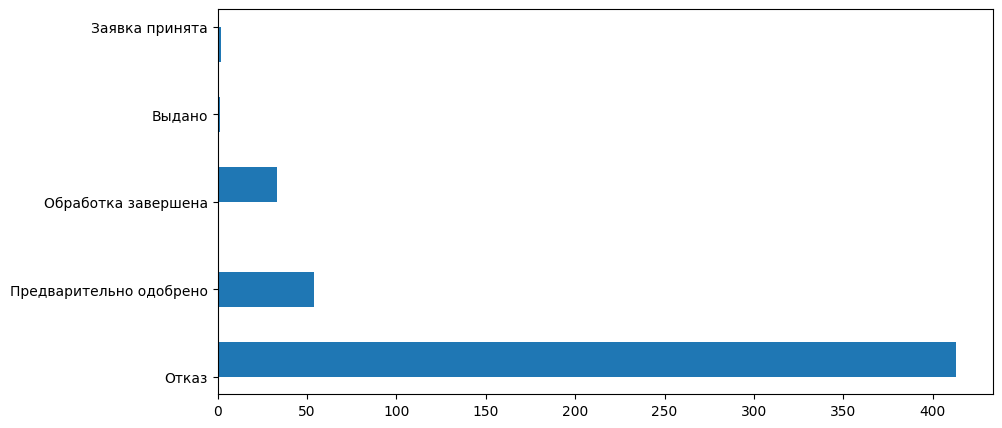

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(analysis_df['Статус'], orientation = 'horizontal')

Text(0.5, 1.0, 'Распределение возраста для двух типов статуса')

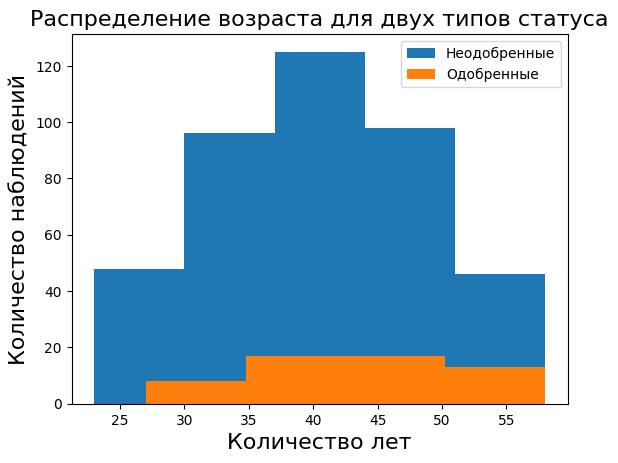

In [ ]:
bins = 5
plt.hist(analysis_df.loc[analysis_df['Статус'] == 'Отказ', 'years_old'], bins, label = 'Неодобренные')
plt.hist(analysis_df.loc[(analysis_df['Статус'] == 'Выдано') |(analysis_df['Статус'] == "Предварительно одобрено"), 'years_old'], bins = 4,  label = 'Одобренные')

plt.legend(loc = 'upper right')
plt.xlabel('Количество лет', fontsize = 16)
plt.ylabel('Количество наблюдений', fontsize = 16)
plt.title('Распределение возраста для двух типов статуса', fontsize = 16)

Text(0.5, 1.0, 'Зависимость выдачи кредита от вида занятости')

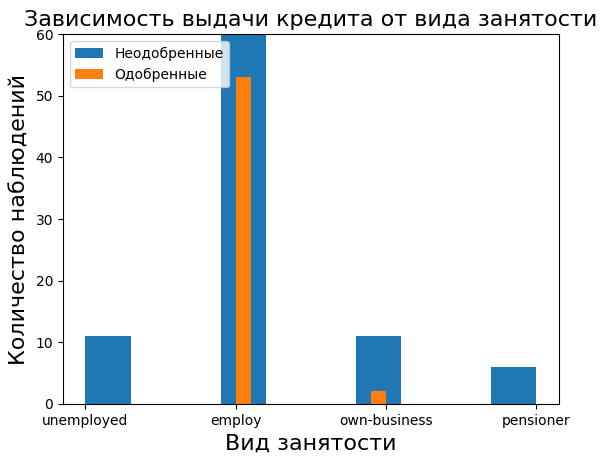

In [ ]:
plt.hist(analysis_df.loc[analysis_df['Статус'] == 'Отказ', 'type_of_employment'], label = 'Неодобренные')
plt.hist(analysis_df.loc[(analysis_df['Статус'] == 'Выдано') |(analysis_df['Статус'] == "Предварительно одобрено"), 'type_of_employment'],  label = 'Одобренные')

plt.ylim([0, 60])
plt.legend(loc = 'upper left')
plt.xlabel('Вид занятости', fontsize = 16)
plt.ylabel('Количество наблюдений', fontsize = 16)
plt.title('Зависимость выдачи кредита от вида занятости', fontsize = 16)

Text(0.5, 1.0, 'Зависимость выдачи кредита от уровня образования')

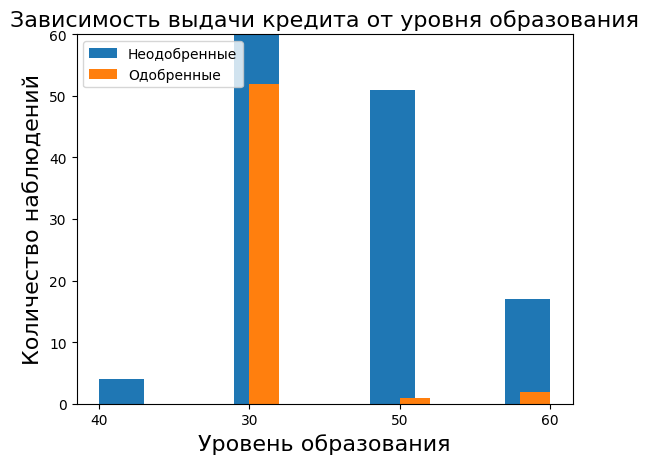

In [ ]:
plt.hist(analysis_df.loc[analysis_df['Статус'] == 'Отказ', 'education_id'], label = 'Неодобренные')
plt.hist(analysis_df.loc[(analysis_df['Статус'] == 'Выдано') |(analysis_df['Статус'] == "Предварительно одобрено"), 'education_id'], label = 'Одобренные')

plt.ylim([0, 60])
plt.legend(loc = 'upper left')
plt.xlabel('Уровень образования', fontsize = 16)
plt.ylabel('Количество наблюдений', fontsize = 16)
plt.title('Зависимость выдачи кредита от уровня образования', fontsize = 16)

Text(0.5, 1.0, 'Распределение величины суммы кредита')

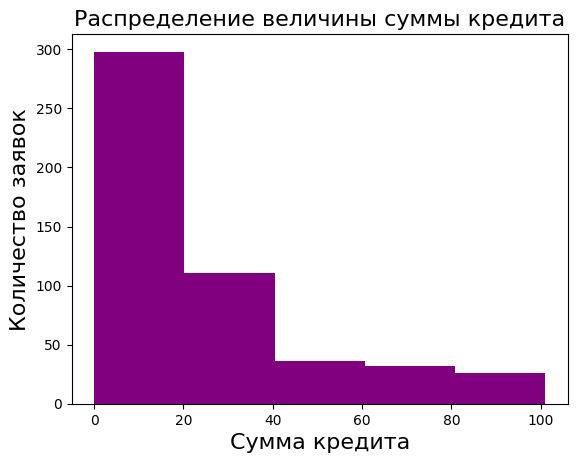

In [ ]:
plt.hist(analysis_df['amount'], bins = 5, color = 'purple')

plt.xscale('linear')
plt.xlabel('Сумма кредита', fontsize = 16)
plt.ylabel('Количество заявок', fontsize = 16)
plt.title('Распределение величины суммы кредита', fontsize = 16)

## Подводя итог, можно сказать, что кредиты пользуются наибольшим спросом среди людей 30-50 лет с постоянным местом работы и среднеспециальным образованием на сумму до 400 000 рублей. Исходя из этого, можно представить образ целевого клиента, поэтому было бы целесообразно проводить рекламную кампанию, настроенную на такую аудиторию. **С большей вероятностью типичный кредитполучатель будет проживать в небольших городах и берет кредит на потребительские расходы - это может быть покупка машины, участка, бытовой техники, кредит на учебу.**

In [ ]:
analysis_df.type_of_employment.unique()

array(['unemployed', 'employ', 'own-business', 'pensioner'], dtype=object)

In [ ]:
#employ_dict = {'unemployed' : 0, 'pensioner': 1, 'own-business': 2, 'employ' : 3}
#analysis_df['type_of_employment'] = analysis_df['type_of_employment'].apply(lambda x: employ_dict[x])

In [ ]:
analysis_df = pd.get_dummies(analysis_df, columns = ['type_of_employment'])


In [ ]:
analysis_df

,Статус,amount,credit_term_id,education_id,date_of_birth,gender,registration_address_city,city,village,Адыгея,...,Челябинская_область,Чечня,Чувашия,Ямало-Ненецкий_АО,Ярославская_область,years_old,type_of_employment_employ,type_of_employment_own-business,type_of_employment_pensioner,type_of_employment_unemployed
0,Отказ,200000,36,40,09021998,М,Самара,Самарская_область,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,25.0,0,0,0,1
1,Отказ,150000,36,30,18111967,М,Волжский,Волгоградская_область,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,56.0,1,0,0,0
2,Отказ,5000000,84,30,18051978,М,Пермь,Пермский_край,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,45.0,1,0,0,0
3,Предварительно одобрено,200000,60,30,13051996,Ж,Мекен-Юрт,village,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,27.0,1,0,0,0
4,Отказ,300000,36,30,25101985,Ж,Мелеуз,Башкортостан,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,38.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,Обработка завершена,400000,24,30,09061994,Ж,Абакан,Хакасия,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,29.0,1,0,0,0
499,Предварительно одобрено,200000,36,30,31011971,М,Наумово,village,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,52.0,1,0,0,0
500,Заявка принята,300000,24,30,03061976,Ж,Владивосток,Приморский_край,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,47.0,1,0,0,0
501,Отказ,300000,36,50,04111977,М,Пришиб,village,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,46.0,1,0,0,0


In [ ]:
gend_dict = {'Ж' : 0, 'М': 1}
analysis_df['gender'] = analysis_df['gender'].apply(lambda x: gend_dict[x])


In [ ]:
analysis_df.columns

Index(['Статус', 'amount', 'credit_term_id', 'education_id', 'date_of_birth',
       'gender', 'registration_address_city', 'city', 'village', 'Адыгея',
       'Алтайский_край', 'Астраханская_область', 'Башкортостан',
       'Белгородская_область', 'Бурятия', 'Владимирская_область',
       'Волгоградская_область', 'Вологодская_область', 'Забайкальский_край',
       'Ивановская_область', 'Иркутская_область', 'Калининградская_область',
       'Калужская_область', 'Карачаево-Черкесия', 'Карелия',
       'Краснодарский_край', 'Курская_область', 'Липецкая_область', 'Марий_Эл',
       'Москва', 'Московская_область', 'Нижегородская_область',
       'Новгородская_область', 'Новосибирская_область', 'Омская_область',
       'Оренбургская_область', 'Орловская_область', 'Пензенская_область',
       'Пермский_край', 'Приморский_край', 'Псковская_область',
       'Ростовская_область', 'Рязанская_область', 'Самарская_область',
       'Санкт-Петербург', 'Саратовская_область', 'Свердловская_область',
 

In [ ]:
analysis_df = analysis_df.drop(columns = ['date_of_birth', 'registration_address_city', 'city'])


In [ ]:
analysis_df

,Статус,amount,credit_term_id,education_id,gender,village,Адыгея,Алтайский_край,Астраханская_область,Башкортостан,...,Челябинская_область,Чечня,Чувашия,Ямало-Ненецкий_АО,Ярославская_область,years_old,type_of_employment_employ,type_of_employment_own-business,type_of_employment_pensioner,type_of_employment_unemployed
0,Отказ,200000,36,40,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,25.0,0,0,0,1
1,Отказ,150000,36,30,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,56.0,1,0,0,0
2,Отказ,5000000,84,30,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,45.0,1,0,0,0
3,Предварительно одобрено,200000,60,30,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,27.0,1,0,0,0
4,Отказ,300000,36,30,0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,38.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,Обработка завершена,400000,24,30,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,29.0,1,0,0,0
499,Предварительно одобрено,200000,36,30,1,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,52.0,1,0,0,0
500,Заявка принята,300000,24,30,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,47.0,1,0,0,0
501,Отказ,300000,36,50,1,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,46.0,1,0,0,0


In [ ]:
analysis_df.loc[analysis_df['Статус']=='Выдано']

,Статус,amount,credit_term_id,education_id,gender,village,Адыгея,Алтайский_край,Астраханская_область,Башкортостан,...,Челябинская_область,Чечня,Чувашия,Ямало-Ненецкий_АО,Ярославская_область,years_old,type_of_employment_employ,type_of_employment_own-business,type_of_employment_pensioner,type_of_employment_unemployed
22,Выдано,3700000,24,30,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,41.0,1,0,0,0


Переменную статуса выберем бинарную 0 - в случае отказа, 1 - в случае одобрения и выдачи кредита
Так, одобрение - это статусы "Предварительно одобрено" и "Выдано, Отказ - "Отказ, а статус "Заявка принята" и "Обработка завершена" будут тестовыми выборками

In [ ]:
analysis_df['Статус'].unique()

array(['Отказ', 'Предварительно одобрено', 'Обработка завершена',
       'Выдано', 'Заявка принята'], dtype=object)

In [ ]:
X_test = analysis_df.loc[(analysis_df['Статус']=='Заявка принята') | (analysis_df['Статус']=='Обработка завершена')].copy()
X_test = X_test.drop(columns = 'Статус', axis=1)
X_test.head()

,amount,credit_term_id,education_id,gender,village,Адыгея,Алтайский_край,Астраханская_область,Башкортостан,Белгородская_область,...,Челябинская_область,Чечня,Чувашия,Ямало-Ненецкий_АО,Ярославская_область,years_old,type_of_employment_employ,type_of_employment_own-business,type_of_employment_pensioner,type_of_employment_unemployed
10,250000,36,50,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,24.0,1,0,0,0
31,2500000,24,30,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,46.0,1,0,0,0
43,300000,24,30,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,29.0,1,0,0,0
58,320000,24,30,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,44.0,1,0,0,0
85,300000,36,30,1,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,56.0,1,0,0,0


In [ ]:
X_train = analysis_df.loc[(analysis_df['Статус'] == 'Отказ') | (analysis_df['Статус'] == 'Предварительно одобрено') | (analysis_df['Статус'] == 'Выдано')]
status_dict = {'Отказ' : 0, 'Предварительно одобрено' : 1,  'Выдано' : 1}
X_train['status'] = X_train['Статус'].apply(lambda x: status_dict[x])
y_train = X_train['status'].copy()
X_train = X_train.drop(columns = ['status', 'Статус'], axis=1)

<ipython-input-52-1d99c0aa369a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['status'] = X_train['Статус'].apply(lambda x: status_dict[x])


Далее построим модель классификации заявок, используя возможности логистической регрессии

In [ ]:
X_train = X_train.astype('int64')
y_train = y_train.astype('int64')
X_test = X_test.astype('int64')

In [ ]:
X_train

,amount,credit_term_id,education_id,gender,village,Адыгея,Алтайский_край,Астраханская_область,Башкортостан,Белгородская_область,...,Челябинская_область,Чечня,Чувашия,Ямало-Ненецкий_АО,Ярославская_область,years_old,type_of_employment_employ,type_of_employment_own-business,type_of_employment_pensioner,type_of_employment_unemployed
0,200000,36,40,1,0,0,0,0,0,0,...,0,0,0,0,0,25,0,0,0,1
1,150000,36,30,1,0,0,0,0,0,0,...,0,0,0,0,0,56,1,0,0,0
2,5000000,84,30,1,0,0,0,0,0,0,...,0,0,0,0,0,45,1,0,0,0
3,200000,60,30,0,1,0,0,0,0,0,...,0,0,0,0,0,27,1,0,0,0
4,300000,36,30,0,0,0,0,0,1,0,...,0,0,0,0,0,38,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,510000,24,30,0,0,0,0,0,0,0,...,0,0,0,0,0,36,1,0,0,0
496,300000,24,30,1,0,0,0,0,0,0,...,0,0,0,0,0,46,1,0,0,0
497,2000000,24,30,1,0,0,0,0,0,0,...,0,0,0,0,0,46,1,0,0,0
499,200000,36,30,1,1,0,0,0,0,0,...,0,0,0,0,0,52,1,0,0,0


Исходя из графика корреляций, предпочтительная будет модель с 9 признаками


<Axes: >

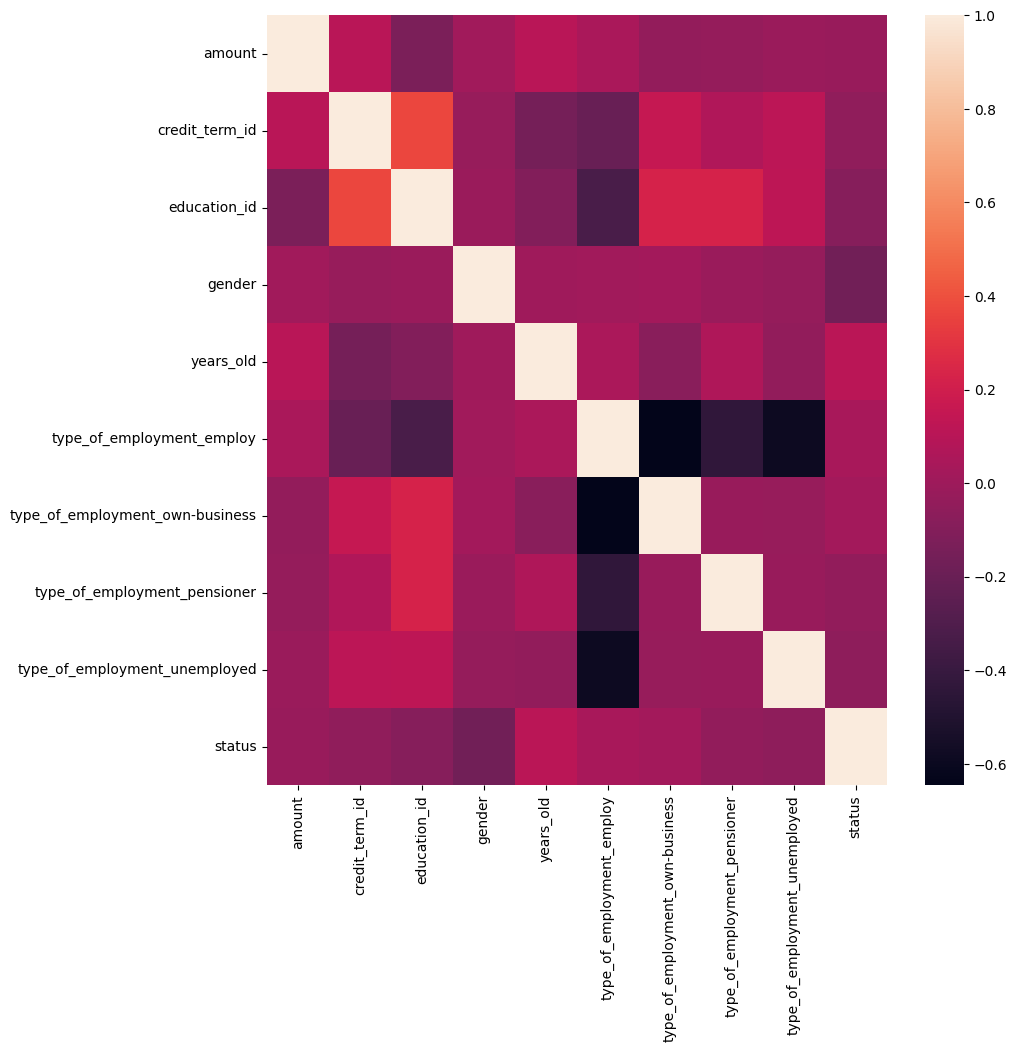

In [ ]:
X_train_5_feat= X_train.copy()[['amount', 'credit_term_id', 'education_id', 'gender', 'years_old']]
X_train_9_feat = X_train.copy()[['amount', 'credit_term_id', 'education_id', 'gender', 'years_old', 'type_of_employment_employ',
       'type_of_employment_own-business', 'type_of_employment_pensioner',
       'type_of_employment_unemployed']]
X_train_full = X_train.copy()

data_train_5_feat = X_train_5_feat.copy().join(y_train)
data_train_9_feat = X_train_9_feat.copy().join(y_train)
data_train_full = X_train_full.copy().join(y_train)

plt.figure(figsize=(10,10))
sns.heatmap(data_train_9_feat.corr())

# Проверим баланс классов и при необходимости их сбалансируем

In [ ]:
 rat = len(data_train_9_feat.status)/sum(data_train_9_feat.status)

In [ ]:
balanced_data = pd.concat([data_train_9_feat.loc[data_train_9_feat.status==0], data_train_9_feat.loc[data_train_9_feat.status==1].loc[data_train_9_feat.loc[data_train_9_feat.status==1].index.repeat(rat)]] )

In [ ]:
balanced_data.status.value_counts()

1    440
0    413
Name: status, dtype: int64

In [ ]:
balanced_data = balanced_data.sample(frac=1).reset_index(drop=True)

In [ ]:
X_train_9_feat = balanced_data.copy().drop(columns = 'status', axis=1)
y_train = balanced_data.copy()[['status']]

Разделим тренировочную выборку еще на тренировочную и тестовую, чтобы максимизировать качество модели, а после предсказать на реаьлных данных X_test


In [ ]:
from sklearn.model_selection import train_test_split
X_tr, X_ts, y_tr, y_ts = train_test_split(X_train_9_feat, y_train, test_size = 0.4)

In [ ]:
#from sklearn.preprocessing import StandardScaler
#ss = StandardScaler()
#X_tr_sc = X_tr.copy()
#X_ts_sc = X_ts.copy()
#X_tr_sc[['amount','credit_term_id',	'education_id', 'years_old']] = ss.fit_transform(X_tr_sc[['amount','credit_term_id',	'education_id', 'years_old']])
#X_ts_sc[['amount','credit_term_id',	'education_id', 'years_old']] = ss.transform(X_ts_sc[['amount','credit_term_id',	'education_id', 'years_old']])
#y_tr = np.array(y_tr)

# Построим модель классификации заявок, используя возможности "Случайного леса"

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model1 = RandomForestClassifier()
model1.fit(X_tr, y_tr)
y_pred1 = model1.predict(X_ts)

<ipython-input-63-fcfd8bc9496d>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model1.fit(X_tr, y_tr)


In [ ]:
y_pred1

array([1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,

In [ ]:
from sklearn.metrics import precision_score, accuracy_score, recall_score
accuracy_score(y_ts, y_pred1), precision_score(y_ts, y_pred1), recall_score(y_ts, y_pred1)

(0.9210526315789473, 0.8701923076923077, 1.0)

In [ ]:
# from sklearn.decomposition import PCA
# pca_test = PCA(n_components=9)
# pca_test.fit(X_tr)
# sns.set(style='whitegrid')
# plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance')
# plt.axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)
# display(plt.show())
# evr = pca_test.explained_variance_ratio_
# cvr = np.cumsum(pca_test.explained_variance_ratio_)
# pca_df = pd.DataFrame()
# pca_df['Cumulative Variance Ratio'] = cvr
# pca_df['Explained Variance Ratio'] = evr
# display(pca_df.head(10))

In [ ]:
from sklearn.model_selection import GridSearchCV
n_estimators = [5,10, 20, 30]
max_depth = [5, 10]
min_samples_split = [4,5, 10, 15]
min_samples_leaf = [4,5, 10, 15]
param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion' : ['gini', 'entropy', 'log_loss']}
gs = GridSearchCV(model1, param_grid, cv = 5, verbose = 1, n_jobs=-1)
gs.fit(X_tr, y_tr)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [5, 10],
                         'min_samples_leaf': [4, 5, 10, 15],
                         'min_samples_split': [4, 5, 10, 15],
                         'n_estimators': [5, 10, 20, 30]},
             verbose=1)

In [ ]:
gs.best_params_

{'criterion': 'log_loss',
 'max_depth': 10,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 20}

In [ ]:
ypr = gs.predict(X_ts)

In [ ]:
precision_score(y_ts, ypr)

0.7924528301886793

**Модель model1 случайного леса дала хорошие показатели точности и полноты, которые можно применять в предсказании решения выдачи кредита получателю**